In [71]:
import aptwrapper
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import matplotlib.dates
import pickle
import datetime as dt
from skimage.segmentation import mark_boundaries
import scipy.stats

from utils import annot, annotv, test_mean_differences

# Spectrum localisation and processing

In [72]:
sample_id = 'recovery_timeline_april_HA'

maps = pickle.load(open('./cache/maps_aligned_processed.pkl', 'rb'))
maps_raw = pickle.load(open('./cache/maps_raw.pkl', 'rb'))

spectra = pickle.load(open('./cache/spectra_veven_processed.pkl', 'rb'))
spectra_raw = pickle.load(open('./cache/spectra_veven_raw.pkl', 'rb'))

spectra = spectra.isel(si=spectra.sample_id==sample_id)
spectra_raw = spectra_raw.isel(si=spectra_raw.sample_id==sample_id)

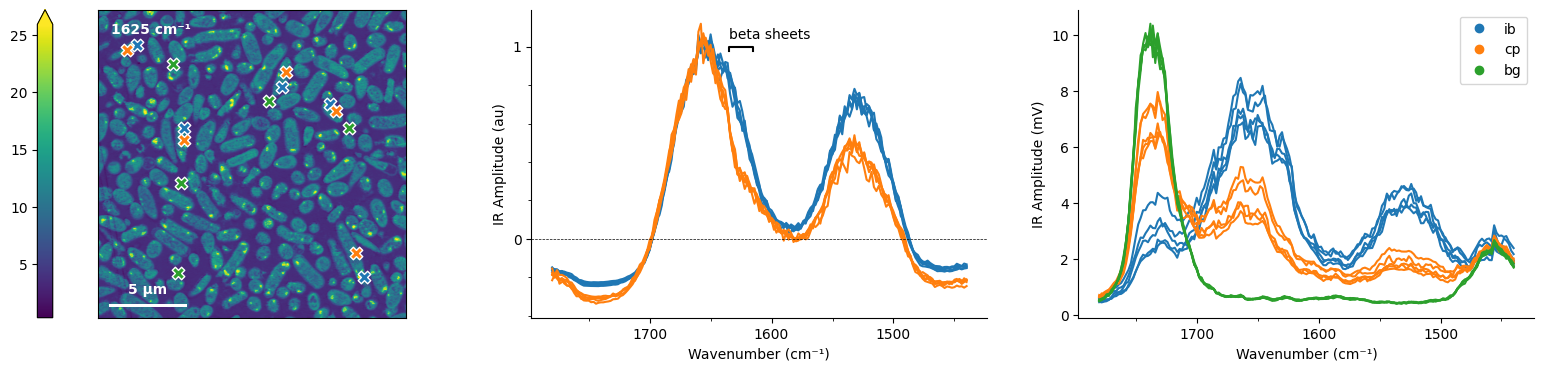

In [73]:
from matplotlib.lines import Line2D
from utils import get_ref_map

def plot_spectrum_example(ax=None, cax=None):
    if ax is None: fig, ax = plt.subplots(1, 3, figsize=(20, 4))

    ref_map = get_ref_map(spectra.isel(si=0), maps_raw)

    vmax = np.nanpercentile(ref_map, 100-.1)
    aptwrapper.plot_map(
        ref_map, ax=ax[0], cmap='viridis', flatten=False, annotation='1625 cm⁻¹', 
        cb_label='IR Amplitude (mV)', vmax=vmax,
        cbar_opts=dict(cax=cax, location='left')
    )

    for s in spectra['IR Amplitude (mV)'].sel(v=slice(1440, 1780)):
        feature = s.feature.item()
        if feature == 'bg': continue
        c = 'C0' if feature == 'ib' else 'C1' if feature == 'cp' else 'C2'
        ax[1].plot(s.v, s, c=c)

    for s in spectra_raw['IR Amplitude (mV)'].sel(v=slice(1440, 1780)):
        feature = s.feature.item()
        c = 'C0' if feature == 'ib' else 'C1' if feature == 'cp' else 'C2'
        ax[2].plot(s.v, s, c=c)
        aptwrapper.mark_location(s, ax=ax[0], c=c)
        ax[2].legend(handles=[
            Line2D([0], [0], color='C0', lw=0, marker='o', label='ib'),
            Line2D([0], [0], color='C1', lw=0, marker='o', label='cp'),
            Line2D([0], [0], color='C2', lw=0, marker='o', label='bg'),
        ])

    ax[1].invert_xaxis()
    ax[2].invert_xaxis()
    ax[1].set(xlabel='Wavenumber (cm⁻¹)', ylabel='IR Amplitude (au)')
    ax[2].set(xlabel='Wavenumber (cm⁻¹)', ylabel='IR Amplitude (mV)')
    sns.despine(ax=ax[1])
    sns.despine(ax=ax[2])
    for a in ax[1:]:
        a.xaxis.set_major_locator(plt.MultipleLocator(100))
        a.xaxis.set_minor_locator(plt.MultipleLocator(50))
    ax[1].yaxis.set_major_locator(plt.MultipleLocator(1))
    ax[1].yaxis.set_minor_locator(plt.MultipleLocator(.2))
    ax[1].axhline(0, c='k', lw=.5, ls='--')

    # annot(ax[1], 1625,20, 'beta sheets')
    ax[1].plot([1635, 1635, 1615, 1615], [.975, 1, 1, .975], c='k')
    ax[1].text(1635, 1.025, 'beta sheets', ha='left', va='bottom')

plot_spectrum_example()

# Spectrum quantification

(-18.737801467219054, 50.956882006011114)


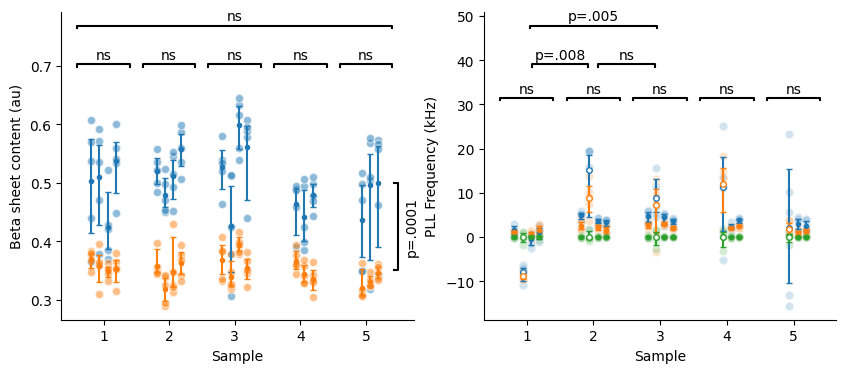

In [74]:
from scipy.stats import bootstrap
spectrum_stats = pickle.load(open('./cache/spectrum_quantification.pkl', 'rb')).query(
    "experiment == 'wt_repeats'"# and feature != 'bg'"
)

def split_plot(
        df, ax, x_major, x_minor, y, hue=None, 
        major_order=None, minor_order=None, hue_order=None, 
        alpha=.5, kind='scatter', error_marker='.', error_marker_size=None,
        error_marker_hollow=False
):
    all_xs = []

    x_major_values = major_order or df[x_major].unique()
    if hue in df and hue_order is None: 
        hue_order = list(df[hue].unique())

    for i in range(len(x_major_values)):
        df1 = df[df[x_major] == x_major_values[i]]

        x_minor_values = minor_order or df1[x_minor].unique()
        num_minor = len(x_minor_values)
    
        for j in range(num_minor):
            df2 = df1[df1[x_minor] == x_minor_values[j]]
            x = 1 + i + (j - num_minor/2 + .5) / num_minor * .5
            all_xs.append(x)

            if hue in df: 
                c = ['C' + str(hue_order.index(f)) for f in df2[hue]]
            else:
                c = np.repeat([hue or 'C0'], len(df2))

            for color, df3 in df2.groupby(c):

                if kind == 'scatter' or kind == 'both':
                    ax.scatter(
                        np.repeat(x, len(df3)), 
                        df3[y],
                        c=color, ec='w', alpha=alpha
                    )

                if (kind == 'error' or kind == 'both') and len(df3) > 0:
                    m = df3[y].mean()
                    ci = bootstrap((df3[y].dropna().to_numpy(),), np.mean, confidence_level=0.95).confidence_interval
                    # for xi, mi, ci_i, c_i in np.broadcast(x, m, ci, c):
                    #     ax.errorbar(xi, mi, ([mi-ci_i.low], [ci_i.high-mi]), c=color_i, capsize=2, marker='.')
                    
                    ax.errorbar(
                        x, m, ([m-ci.low], [ci.high-m]), 
                        c=color, capsize=2, marker=error_marker, ms=error_marker_size,
                        mfc='w' if error_marker_hollow else color,
                    )

    return all_xs

import matplotlib.scale

def plot_spectrum_stats(ax=None):
    if ax is None: fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    split_plot(
        spectrum_stats.query('feature!="bg"'), ax[0], 
        x_major='sample_id', x_minor='repeat', 
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        y='beta', 
        hue='feature', #hue_order=['ib', 'cp', 'bg']
        kind='both'
    )

    # PLL except for repeat 2
    split_plot(
        spectrum_stats.assign(pllt=np.arctan(spectrum_stats.pll)).query('repeat!=2'), ax[1], 
        x_major='sample_id', x_minor='repeat', 
        y='pll', 
        hue='feature', #hue_order=['ib', 'cp', 'bg']
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        kind='both',
        alpha=.2,
    )

    # PLL repeat 2
    split_plot(
        spectrum_stats.assign(pllt=np.arctan(spectrum_stats.pll)).query('repeat==2'), ax[1], 
        x_major='sample_id', x_minor='repeat', 
        y='pll', 
        hue='feature', #hue_order=['ib', 'cp', 'bg']
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        kind='both',
        alpha=.2,
        error_marker='o', error_marker_size=4, error_marker_hollow=True
    )

    n = len(spectrum_stats.sample_id.unique())
    # ax[0].set_xticks(range(1,n+1), ['MA', 'MB', 'MC', 'O', 'J'])
    # ax[1].set_xticks(range(1,n+1), ['MA', 'MB', 'MC', 'O', 'J'])
    ax[0].set_xlabel('Sample')
    ax[1].set_xlabel('Sample')
    ax[0].set_ylabel('Beta sheet content (au)')
    ax[1].set_ylabel('PLL Frequency (kHz)')
    # ax[1].set_yscale('asinh')
    # ax[1].set_yticks
    sns.despine(ax=ax[0])
    sns.despine(ax=ax[1])

    annot(ax[0], [1,2,3,4,5], .4, 'ns')
    annot(ax[0], 3, 2.4, 'ns')
    annotv(ax[0], .425, .075, 'p=.0001')

    annot(ax[1], [1,2,3,4,5], .4, 'ns')
    annot(ax[1], [1.5, 2.5], .425, ['p=.008', 'ns'])
    annot(ax[1], 2, .95, 'p=.005')

    print(ax[1].get_ylim())

plot_spectrum_stats()

Beta: no technical variability

In [75]:
test_mean_differences(
    spectrum_stats.query('feature!="bg"'), 
    outcome='beta', 
    groupby=['sample_id', 'feature'], 
    subgroups='repeat'
)

reject_H0  using_anova    p_anova  p_kruskal  \
sample_id      feature                                                 
wt_repeats_J10 cp           False         True   3.481350   4.736752   
               ib           False         True  22.969933  31.669425   
wt_repeats_M1A cp           False         True  25.029644  11.959813   
               ib           False         True   9.463044   8.555662   
wt_repeats_M1B cp           False         True   8.806272   3.693558   
               ib           False         True   1.244786   2.441359   
wt_repeats_M1C cp           False         True   1.006432   1.581772   
               ib           False         True   0.239206   0.523308   
wt_repeats_O21 cp           False         True   4.436286   4.201122   
               ib           False         True  29.165933  26.189320   

                                               p_shapiro  p_bartlett  \
sample_id      feature                                                 
wt_repeats_J10 cp               [51.186, 18.833, 50.687]   52.599972   
               ib                [3.186, 15.432, 51.695]   22.033976   
wt_repeats_M1A cp         [15.411, 20.808, 44.83, 29.88]   12.910196   
               ib       [36.738, 29.299, 17.664, 31.121]   35.172326   
wt_repeats_M1B cp         [1.071, 12.408, 2.861, 40.898]   20.909610   
               ib       [53.932, 26.089, 37.183, 45.416]   50.520521   
wt_repeats_M1C cp        [14.641, 11.456, 35.79, 53.434]   31.259649   
               ib        [41.494, 26.864, 21.365, 0.459]   25.663469   
wt_repeats_O21 cp                  [0.543, 7.11, 33.161]    9.537586   
               ib                  [6.048, 4.981, 5.249]   49.909177   

                         n_per_group  bonferroni_multiplier  
sample_id      feature                                       
wt_repeats_J10 cp          [5, 5, 5]                     56  
               ib          [5, 5, 5]                     56  
wt_repeats_M1A cp       [5, 5, 5, 5]                     56  
               ib       [5, 5, 5, 5]                     56  
wt_repeats_M1B cp       [5, 5, 5, 5]                     56  
               ib       [5, 5, 5, 5]                     56  
wt_repeats_M1C cp       [5, 5, 5, 5]                     56  
               ib       [5, 5, 5, 5]                     56  
wt_repeats_O21 cp          [5, 5, 5]                     56  
               ib          [5, 5, 5]                     56

Beta: no biological variability

In [76]:
test_mean_differences(
    spectrum_stats,#.query('feature!="bg"'), 
    outcome='beta', 
    groupby='feature',
    subgroups='sample_id',
    mean_over='repeat'
)

reject_H0  using_anova   p_anova  p_kruskal  \
feature                                                
bg           False         True  9.552328  12.108357   
cp           False         True  5.055621   4.623332   
ib           False         True  7.880346   6.309308   

                                       p_shapiro  p_bartlett      n_per_group  \
feature                                                                         
bg         [6.193, 16.934, 4.279, 1.401, 14.115]   11.197223  [3, 4, 4, 4, 3]   
cp       [12.105, 13.903, 5.914, 19.397, 16.085]   14.456406  [3, 4, 4, 4, 3]   
ib         [16.879, 6.52, 18.894, 13.154, 2.554]    8.683159  [3, 4, 4, 4, 3]   

         bonferroni_multiplier  
feature                         
bg                          21  
cp                          21  
ib                          21

In [77]:
5.05/21

0.24047619047619045

Beta: IBs have more beta than CPs

In [78]:
dfs = spectrum_stats.groupby(['sample_id', 'feature']).mean(numeric_only=True)
print(scipy.stats.shapiro(dfs.query('feature=="ib"').beta))
print(scipy.stats.shapiro(dfs.query('feature=="cp"').beta))
print(scipy.stats.bartlett(dfs.query('feature=="ib"').beta, dfs.query('feature=="cp"').beta))
t=scipy.stats.ttest_rel(dfs.query('feature=="ib"').beta, dfs.query('feature=="cp"').beta)
print(t)
print(t.confidence_interval())
print('alpha', .05/4)
print('p_adj', t.pvalue*4)

ShapiroResult(statistic=0.9622716494208537, pvalue=0.8237070889073673)
ShapiroResult(statistic=0.9695085779831579, pvalue=0.8720902520260282)
BartlettResult(statistic=2.3089171660766206, pvalue=0.1286336327459019)
TtestResult(statistic=14.03150734070341, pvalue=0.00014968199720290953, df=4)
ConfidenceInterval(low=0.11714268150785084, high=0.17493715973937995)
alpha 0.0125
p_adj 0.0005987279888116381


T-test of ib/cp beta ratio

In [79]:
df = dfs.beta.unstack().assign(ratio=lambda x: x.ib/x.cp)
print(scipy.stats.shapiro(df.ratio))
t = scipy.stats.ttest_1samp(df.ratio, 1)
print(t)
print(t.confidence_interval())
print(df.ratio.mean())

ShapiroResult(statistic=0.9682353948768786, pvalue=0.8638118171961201)
TtestResult(statistic=14.15229129787441, pvalue=0.00014471883400614125, df=4)
ConfidenceInterval(low=1.3359238519108696, high=1.4998983147438056)
1.4179110833273376


PLL: no technical variability, if excluding repeat 2

In [80]:
test_mean_differences(
    spectrum_stats.query('feature!="bg" and repeat!=2'), 
    outcome='pll', 
    groupby=['sample_id', 'feature'], 
    subgroups='repeat'
)

reject_H0  using_anova    p_anova  p_kruskal  \
sample_id      feature                                                 
wt_repeats_J10 cp           False         True   2.871260   5.390514   
               ib           False         True   0.382683   0.749506   
wt_repeats_M1A cp           False         True   4.942243   9.012760   
               ib           False         True   3.453036   2.267417   
wt_repeats_M1B cp           False         True  10.110782  12.165954   
               ib           False         True   1.137786   3.000087   
wt_repeats_M1C cp           False         True   0.943684   2.714591   
               ib           False         True  15.525900   8.319826   
wt_repeats_O21 cp           False         True  17.770584  27.669374   
               ib           False         True  30.871740  27.669374   

                                       p_shapiro  p_bartlett n_per_group  \
sample_id      feature                                                     
wt_repeats_J10 cp               [37.268, 19.822]   14.042823      [5, 5]   
               ib                [30.475, 41.84]   29.492128      [5, 5]   
wt_repeats_M1A cp       [28.581, 45.996, 31.347]    2.048433   [5, 5, 5]   
               ib        [44.138, 11.402, 6.894]   36.242554   [5, 5, 5]   
wt_repeats_M1B cp        [20.711, 41.902, 9.359]   31.279876   [5, 5, 5]   
               ib         [16.628, 6.412, 1.321]   35.559927   [5, 5, 5]   
wt_repeats_M1C cp       [12.836, 38.372, 11.786]   23.486905   [5, 5, 5]   
               ib         [20.845, 8.958, 3.768]   24.334804   [5, 5, 5]   
wt_repeats_O21 cp               [27.406, 10.863]   34.015474      [5, 5]   
               ib                [16.807, 20.21]   44.179757      [5, 5]   

                        bonferroni_multiplier  
sample_id      feature                         
wt_repeats_J10 cp                          46  
               ib                          46  
wt_repeats_M1A cp                          46  
               ib                          46  
wt_repeats_M1B cp                          46  
               ib                          46  
wt_repeats_M1C cp                          46  
               ib                          46  
wt_repeats_O21 cp                          46  
               ib                          46

PLL: biological variability within IBs when excluding repeat 2 (and samples oct and jan, becuase not enough measurements)

In [81]:
test_mean_differences(
    spectrum_stats
        .query('feature!="bg"')
        .query('repeat != 2 and sample_id.str.contains("M1")')
    ,
    outcome='pll', 
    groupby='feature',
    subgroups='sample_id',
    mean_over='repeat'
)

reject_H0  using_anova   p_anova  p_kruskal              p_shapiro  \
feature                                                                       
cp           False         True  0.317470   0.793939  [9.261, 5.692, 4.711]   
ib            True         True  0.036188   0.608101  [2.533, 2.668, 4.025]   

         p_bartlett n_per_group  bonferroni_multiplier  
feature                                                 
cp         9.734460   [3, 3, 3]                     10  
ib         7.424791   [3, 3, 3]                     10

In [82]:
import utils
utils.tukey_hsd(
    spectrum_stats
    .query('feature=="ib"')
    .query('repeat != 2 and sample_id.str.contains("M1")')
    ,
    outcome='pll', 
    groupby='sample_id', 
    mean_over=['repeat']
)

<class 'statsmodels.iolib.table.SimpleTable'>

PLL: only thing you can say is that IBs are stiffer than CPs

In [83]:
test_mean_differences(
    spectrum_stats.query('feature != "bg"'), 
    outcome='pll', 
    groupby='feature', 
    mean_over=['sample_id', 'repeat']
)

reject_H0                         False
using_anova                       False
p_anova                        1.630002
p_kruskal                      0.399708
p_shapiro                [0.005, 0.138]
p_bartlett                     2.303971
n_per_group                    [18, 18]
bonferroni_multiplier                 4
dtype: object

In [84]:
test_mean_differences(
    spectrum_stats
    .query('repeat != 2 and sample_id.str.contains("M1")')
    ,
    outcome='pll', 
    groupby='feature', 
    mean_over='sample_id'
)

reject_H0                                False
using_anova                              False
p_anova                               0.305745
p_kruskal                              0.30405
p_shapiro                [2.344, 3.324, 0.714]
p_bartlett                                 0.0
n_per_group                          [3, 3, 3]
bonferroni_multiplier                        5
dtype: object

# Map processing

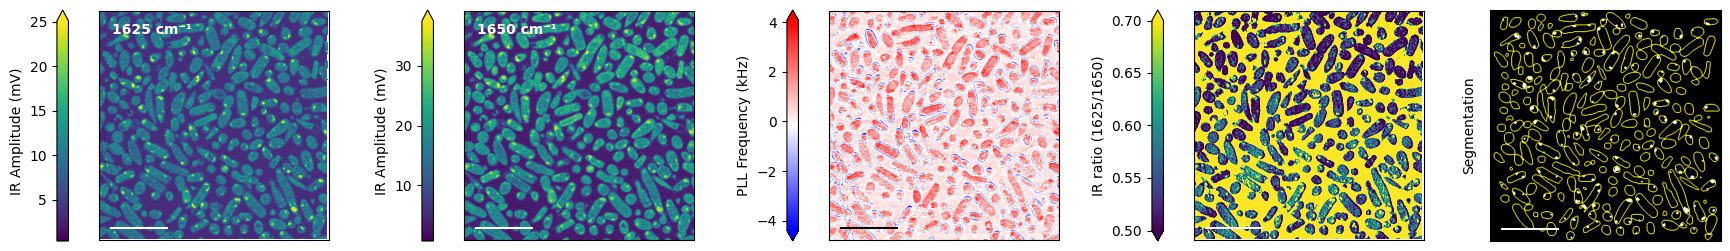

In [85]:
maps = pickle.load(open('./cache/maps_aligned_processed.pkl', 'rb'))

def plot(ax, hmap, cb_label, title='', vmin=None, vmax=None, cmap='viridis', **kwargs):
    vmin=vmin if vmin is not None else np.nanpercentile(hmap,     .1)
    vmax=vmax if vmax is not None else np.nanpercentile(hmap, 100-.1)
    
    aptwrapper.plot_map(
        hmap, ax=ax, **kwargs,
        flatten=False, cmap=cmap, cb_label=cb_label,
        vmin=vmin, vmax=vmax,
    )
    ax.set_title(title)

def plot_maps_example(ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 5, figsize=(22, 3), gridspec_kw=dict(width_ratios=[1, 1, 1, 1, .8]))

    im = maps['recovery_timeline_april_HA']

    plot(ax[0], im.amp1625, 'IR Amplitude (mV)', vmin=0, annotation='1625 cm⁻¹', show_sb_val=False)
    plot(ax[1], im.amp1650, 'IR Amplitude (mV)', vmin=0, annotation='1650 cm⁻¹', show_sb_val=False)
    plot(ax[2], im.pll, 'PLL Frequency (kHz)', cmap='bwr', sb_color='k', show_sb_val=False)
    plot(ax[3], im.amp1625/im.amp1650, 'IR ratio (1625/1650)', vmin=.5, vmax=.7, show_sb_val=False)
    ax[4].imshow(mark_boundaries(
        im.ib_labels.astype(bool),
        im.cell_labels.astype(bool),
        mode='thick'
    ), extent=aptwrapper.get_im_extent(im.pll))
    ax[4].set(xticks=[], yticks=[])
    ax[4].set_ylabel('Segmentation', labelpad=10)
    aptwrapper.add_scalebar(ax[4], show_value=False)

    for a in ax[0].figure.get_axes():
        if a.get_ylabel() == 'IR ratio (1625/1650)':
            a.yaxis.set_major_locator(plt.MultipleLocator(.05))
            
plot_maps_example()

# Map quantification

## Beta ratio

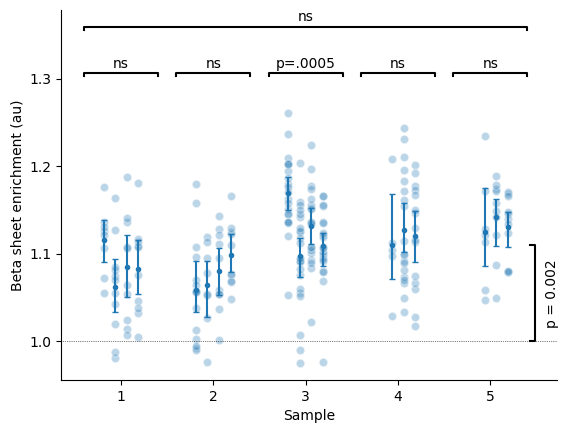

In [86]:
ibtable = pickle.load(open('./cache/ibtable.pkl', 'rb')).query("experiment == 'wt_repeats'")
celltable = pickle.load(open('./cache/celltable.pkl', 'rb')).query("experiment == 'wt_repeats'")

def plot_map_beta(ax=None):
    if ax is None: fig, ax = plt.subplots()
    split_plot(
        ibtable, ax, 
        x_major='sample_id', x_minor='repeat', 
        y='beta_ratio_fc', 
        alpha=.3,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        hue='C0'
    )
    ax.set_xlabel('Sample')
    ax.set_ylabel('Beta sheet enrichment (au)')
    sns.despine(ax=ax)
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
    ax.set_xticks(range(1,6), range(1,6))
    ax.axhline(1, c='k', ls=':', lw=.5)

    annot(ax, [1,2,3,4,5], .4, ['ns', 'ns', 'p=.0005', 'ns', 'ns'])
    annot(ax, 3, 2.4, 'ns')
    annotv(ax, 1.055, .055, 'p = 0.002')
    
plot_map_beta()

Technical variability: only within sample MC

In [87]:
test_mean_differences(
    ibtable, 
    outcome='beta_ratio_fc', 
    groupby='sample_id', 
    subgroups='repeat'
)

reject_H0  using_anova    p_anova  p_kruskal  \
sample_id                                                      
wt_repeats_J10      False         True  23.897144  25.774806   
wt_repeats_M1A      False         True   6.191973   6.139369   
wt_repeats_M1B      False         True   6.354871   5.054460   
wt_repeats_M1C       True         True   0.000528   0.000821   
wt_repeats_O21      False         True  20.883684  11.382640   

                                      p_shapiro  p_bartlett       n_per_group  \
sample_id                                                                       
wt_repeats_J10           [14.407, 5.485, 10.78]   26.780165       [5, 19, 15]   
wt_repeats_M1A  [19.675, 23.631, 16.45, 16.882]   18.303449   [8, 11, 10, 10]   
wt_repeats_M1B  [4.731, 17.593, 16.914, 13.645]   15.142158   [15, 8, 10, 10]   
wt_repeats_M1C  [16.821, 14.159, 25.331, 0.534]   16.644891  [21, 23, 19, 20]   
wt_repeats_O21           [18.995, 4.113, 1.302]    7.615471       [7, 10, 11]   

                bonferroni_multiplier  
sample_id                              
wt_repeats_J10                     28  
wt_repeats_M1A                     28  
wt_repeats_M1B                     28  
wt_repeats_M1C                     28  
wt_repeats_O21                     28

No biological variability

In [88]:
test_mean_differences(
    ibtable, 
    outcome='beta_ratio_fc', 
    groupby='sample_id',
    mean_over='repeat'
)

reject_H0                                             False
using_anova                                            True
p_anova                                            0.060095
p_kruskal                                          0.180506
p_shapiro                [5.09, 4.593, 4.742, 4.647, 4.042]
p_bartlett                                         2.293799
n_per_group                                 [3, 4, 4, 4, 3]
bonferroni_multiplier                                     7
dtype: object

95% CI of beta sheet enrichment: mean 1.11 (1.07-1.14)

In [89]:
df = ibtable.groupby('sample_id').mean(numeric_only=True)
t = scipy.stats.ttest_1samp(df.beta_ratio_fc, 1)
print('mean beta ratio fc:', df.beta_ratio_fc.mean())
print('alpha', .05/2)
print(scipy.stats.shapiro(df.beta_ratio_fc))
print(t)
print(t.confidence_interval(.975))
print('p_adj', t.pvalue*2)

mean beta ratio fc: 1.1078948167061784
alpha 0.025
ShapiroResult(statistic=0.8427658262431758, pvalue=0.17271341935418283)
TtestResult(statistic=8.940792919643938, pvalue=0.0008655033444077818, df=4)
ConfidenceInterval(low=1.0657133026288312, high=1.1500763307835258)
p_adj 0.0017310066888155636


## PLL

### PLL diff

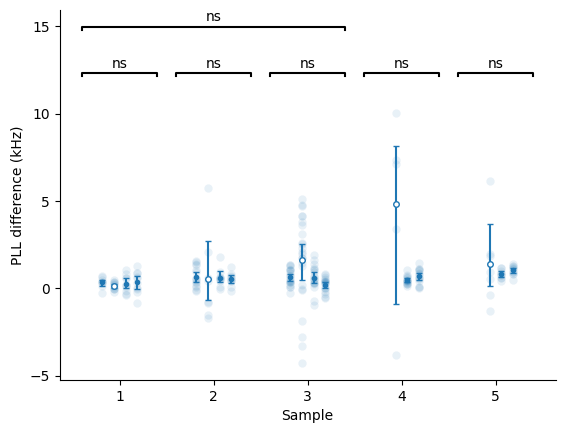

In [ ]:
from scipy.stats import ttest_1samp
def plot_map_pll_diff(ax=None):
    if ax is None: fig, ax = plt.subplots()

    # Except repeat 2
    split_plot(
        ibtable.query('repeat!=2'), ax, 
        x_major='sample_id', x_minor='repeat', 
        y='ib_pll_diff', 
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        hue='C0',
        minor_order=[1,2,3,4],
    )
    # Repeat 2
    split_plot(
        ibtable.query('repeat==2'), ax, 
        x_major='sample_id', x_minor='repeat', 
        y='ib_pll_diff', 
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        error_marker='o', error_marker_size=4, error_marker_hollow=True,
        hue='C0',
    )
    ax.set_xlabel('Sample')
    ax.set_ylabel('PLL difference (kHz)')
    sns.despine(ax=ax)    
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))
    # ax.set_xticks(range(1,6), ['MA', 'MB', 'MC', 'O', 'J'])

    annot(ax, [1,2,3,4,5], .4, 'ns')
    annot(ax, 2, 1.4, 'ns')

plot_map_pll_diff()

No technical variability in `ib_pll_diff` (even without repeat 2)

In [108]:
display(test_mean_differences(
    ibtable.query('repeat!=2'), 
    outcome='ib_pll_diff', 
    groupby='sample_id', 
    subgroups='repeat'
))

reject_H0  using_anova    p_anova  p_kruskal  \
sample_id                                                      
wt_repeats_J10      False         True   1.054041   1.578199   
wt_repeats_M1A      False         True  20.721852  18.639866   
wt_repeats_M1B      False         True  19.024832  21.516661   
wt_repeats_M1C      False         True   0.569115   0.408285   
wt_repeats_O21      False         True   1.812527   1.543776   

                              p_shapiro  p_bartlett   n_per_group  \
sample_id                                                           
wt_repeats_J10           [2.19, 15.516]    0.120480      [19, 15]   
wt_repeats_M1A   [7.893, 15.366, 20.29]    2.660845   [9, 10, 10]   
wt_repeats_M1B   [5.297, 1.697, 19.931]    9.784128  [15, 10, 10]   
wt_repeats_M1C  [12.066, 13.478, 4.746]    0.623012  [21, 19, 20]   
wt_repeats_O21         [18.464, 15.444]   20.684329      [10, 11]   

                bonferroni_multiplier  
sample_id                              
wt_repeats_J10                     23  
wt_repeats_M1A                     23  
wt_repeats_M1B                     23  
wt_repeats_M1C                     23  
wt_repeats_O21                     23

No biological variability in `ib_pll_diff`

In [109]:
test_mean_differences(
    ibtable.query('repeat!=2 and sample_id.str.contains("M1")'), 
    outcome='ib_pll_diff', 
    groupby='sample_id',
    mean_over='repeat'
)

reject_H0                                False
using_anova                               True
p_anova                               0.689786
p_kruskal                             1.260691
p_shapiro                [1.332, 3.899, 0.394]
p_bartlett                            0.546285
n_per_group                          [3, 3, 3]
bonferroni_multiplier                        5
dtype: object

IBs are stiffer than CPs

In [110]:
df = ibtable.groupby('sample_id').mean(numeric_only=True)
print('mean ib pll diff:', df.ib_pll_diff.mean())
print('alpha:', .05/2)
print(scipy.stats.shapiro(df.ib_pll_diff))
t = scipy.stats.ttest_1samp(df.ib_pll_diff, 0)
print(t)
print(t.confidence_interval())

mean ib pll diff: 0.7695936926662029
alpha: 0.025
ShapiroResult(statistic=0.9389847230017107, pvalue=0.6587693143901328)
TtestResult(statistic=5.002536733556063, pvalue=0.007477005725232818, df=4)
ConfidenceInterval(low=0.3424634675823231, high=1.1967239177500828)


### PLL means

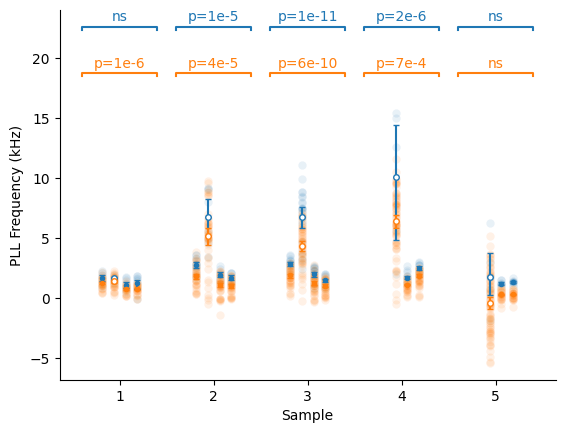

In [165]:
from scipy.stats import ttest_1samp
def plot_map_pll(ax=None):
    if ax is None: fig, ax = plt.subplots()
    split_plot(
        ibtable.query('repeat!=2'), ax, 
        x_major='sample_id', x_minor='repeat', 
        y='ib_pll_mean', 
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
    )
    split_plot(
        ibtable.query('repeat==2'), ax, 
        x_major='sample_id', x_minor='repeat', 
        y='ib_pll_mean', 
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        error_marker='o', error_marker_size=4, error_marker_hollow=True
    )
    split_plot(
        celltable.query('repeat!=2'), ax, 
        x_major='sample_id', x_minor='repeat', 
        y='cp_pll_mean', 
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        hue='C1'
    )
    split_plot(
        celltable.query('repeat==2'), ax, 
        x_major='sample_id', x_minor='repeat', 
        y='cp_pll_mean', 
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        hue='C1',
        error_marker='o', error_marker_size=4, error_marker_hollow=True
    )
    ax.set_xlabel('Sample')
    ax.set_ylabel('PLL Frequency (kHz)')
    sns.despine(ax=ax)    

    annot(ax, [1,2,3,4,5], .4, ['p=1e-6', 'p=4e-5', 'p=6e-10', 'p=7e-4', 'ns'], c='C1')
    # annot(ax, 3, 2.4, 'ns', c='C1')
    annot(ax, [1,2,3,4,5], .4, ['ns', 'p=1e-5', 'p=1e-11', 'p=2e-6', 'ns'], c='C0')
    # annot(ax, 3, 2.4, 'ns', c='C0')
    
    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    fig.savefig('../figures/supp_pllmeans.pdf', bbox_inches='tight')

plot_map_pll()

Some technical differences in `ib_pll_mean`, even without repeat 2

In [93]:
display(test_mean_differences(
    ibtable.query('repeat!=2'), 
    outcome='ib_pll_mean', 
    groupby='sample_id', 
    subgroups='repeat',
))

reject_H0  using_anova       p_anova     p_kruskal  \
sample_id                                                            
wt_repeats_J10       True         True  2.227198e-06  3.617932e-04   
wt_repeats_M1A      False         True  7.803455e-01  6.327947e-01   
wt_repeats_M1B       True         True  1.109216e-05  5.900523e-04   
wt_repeats_M1C       True         True  1.091566e-11  9.455286e-08   
wt_repeats_O21      False         True  2.775178e+00  3.201608e+00   

                              p_shapiro  p_bartlett   n_per_group  \
sample_id                                                           
wt_repeats_J10          [0.347, 18.003]    9.607507      [19, 15]   
wt_repeats_M1A  [21.894, 16.611, 2.994]   10.705036   [9, 10, 10]   
wt_repeats_M1B  [11.275, 10.143, 2.232]    6.693989  [15, 10, 10]   
wt_repeats_M1C   [20.939, 2.081, 5.888]    4.164271  [21, 19, 20]   
wt_repeats_O21           [16.529, 4.43]   16.284577      [10, 11]   

                bonferroni_multiplier  
sample_id                              
wt_repeats_J10                     23  
wt_repeats_M1A                     23  
wt_repeats_M1B                     23  
wt_repeats_M1C                     23  
wt_repeats_O21                     23

Some technical differences in `cp_pll_mean`, even without repeat 2

In [111]:
display(test_mean_differences(
    ibtable.query('repeat!=2'), 
    outcome='cp_pll_mean', 
    groupby='sample_id', 
    subgroups='repeat'
))

reject_H0  using_anova       p_anova     p_kruskal  \
sample_id                                                            
wt_repeats_J10       True         True  7.495395e-04  3.848568e-03   
wt_repeats_M1A       True         True  1.467222e-06  1.980263e-03   
wt_repeats_M1B       True         True  4.065188e-05  1.597235e-03   
wt_repeats_M1C       True         True  6.298688e-10  4.119095e-07   
wt_repeats_O21      False         True  4.323383e+00  2.088686e+00   

                             p_shapiro  p_bartlett   n_per_group  \
sample_id                                                          
wt_repeats_J10        [22.722, 20.086]    6.196727      [19, 15]   
wt_repeats_M1A   [1.316, 2.133, 4.841]   10.428319   [9, 10, 10]   
wt_repeats_M1B  [16.112, 4.868, 5.947]    9.391945  [15, 10, 10]   
wt_repeats_M1C   [8.497, 0.175, 2.986]    2.843786  [21, 19, 20]   
wt_repeats_O21          [2.887, 0.654]    7.878649      [10, 11]   

                bonferroni_multiplier  
sample_id                              
wt_repeats_J10                     23  
wt_repeats_M1A                     23  
wt_repeats_M1B                     23  
wt_repeats_M1C                     23  
wt_repeats_O21                     23

No biological differences

In [133]:
test_mean_differences(
    ibtable.query('repeat!=2 and sample_id.str.contains("M1")'), 
    outcome='ib_pll_mean', 
    groupby='sample_id',
    mean_over='repeat'
)

reject_H0                                False
using_anova                               True
p_anova                               1.107931
p_kruskal                             0.965599
p_shapiro                [2.085, 2.141, 3.786]
p_bartlett                            3.075166
n_per_group                          [3, 3, 3]
bonferroni_multiplier                        5
dtype: object

In [134]:
test_mean_differences(
    ibtable.query('repeat!=2 and sample_id.str.contains("M1")'), 
    outcome='cp_pll_mean', 
    groupby='sample_id',
    mean_over='repeat'
)

reject_H0                               False
using_anova                              True
p_anova                              1.527943
p_kruskal                            1.260691
p_shapiro                [0.652, 1.66, 1.193]
p_bartlett                           3.570271
n_per_group                         [3, 3, 3]
bonferroni_multiplier                       5
dtype: object

## PLL z

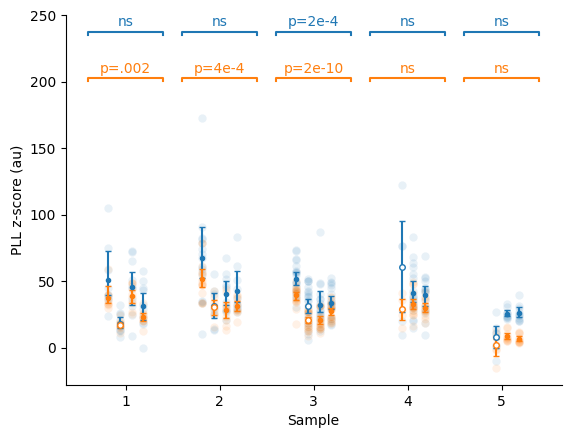

In [166]:
def plot_pll_z(ax=None):
    if ax is None: fig, ax = plt.subplots()
    
    split_plot(
        ibtable.query('repeat!=2'),
        plt.gca(),
        x_major='sample_id', x_minor='repeat',
        # y='ib_pll_diff',
        y='ib_pll_z_mean',
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
    )
    split_plot(
        ibtable.query('repeat==2'),
        plt.gca(),
        x_major='sample_id', x_minor='repeat',
        # y='ib_pll_diff',
        y='ib_pll_z_mean',
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        error_marker='o', error_marker_size=4, error_marker_hollow=True
    )

    split_plot(
        ibtable.query('repeat!=2'),
        plt.gca(),
        x_major='sample_id', x_minor='repeat',
        # y='ib_pll_diff',
        y='cp_pll_z_mean',
        hue='C1',
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
    )
    split_plot(
        ibtable.query('repeat==2'),
        plt.gca(),
        x_major='sample_id', x_minor='repeat',
        # y='ib_pll_diff',
        y='cp_pll_z_mean',
        hue='C1',
        alpha=.1,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        error_marker='o', error_marker_size=4, error_marker_hollow=True
    )

    ax.set_ylabel('PLL z-score (au)')
    ax.set_xlabel('Sample')
    sns.despine(ax=ax)

    annot(ax, [1,2,3,4,5], .4, ['p=.002', 'p=4e-4', 'p=2e-10', 'ns', 'ns'], c='C1')
    annot(ax, [1,2,3,4,5], .4, ['ns', 'ns', 'p=2e-4', 'ns', 'ns'], c='C0')

    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    fig.savefig('../figures/supp_pllzscore.pdf', bbox_inches='tight')
    
plot_pll_z()

Technical variability in ibmean

In [150]:
display(test_mean_differences(
    ibtable.query('repeat!=2'), 
    outcome='ib_pll_z_mean', 
    groupby='sample_id', 
    subgroups='repeat',
))

reject_H0  using_anova    p_anova  p_kruskal  \
sample_id                                                      
wt_repeats_J10      False         True  16.448697  22.681763   
wt_repeats_M1A      False         True   3.202749   3.847300   
wt_repeats_M1B      False         True   0.802352   0.583731   
wt_repeats_M1C       True         True   0.000287   0.000195   
wt_repeats_O21      False         True  17.969643  20.423993   

                              p_shapiro  p_bartlett   n_per_group  \
sample_id                                                           
wt_repeats_J10          [6.441, 21.219]   11.019492      [19, 15]   
wt_repeats_M1A  [1.555, 17.111, 21.136]   13.629513   [9, 10, 10]   
wt_repeats_M1B    [0.65, 12.929, 0.734]    0.198569  [15, 10, 10]   
wt_repeats_M1C   [16.638, 0.056, 7.633]    3.205697  [21, 19, 20]   
wt_repeats_O21           [2.113, 2.536]    4.096550      [10, 11]   

                bonferroni_multiplier  
sample_id                              
wt_repeats_J10                     23  
wt_repeats_M1A                     23  
wt_repeats_M1B                     23  
wt_repeats_M1C                     23  
wt_repeats_O21                     23

Technical variability in cpmean

In [151]:
display(test_mean_differences(
    ibtable.query('repeat!=2'), 
    outcome='cp_pll_z_mean', 
    groupby='sample_id', 
    subgroups='repeat',
))

reject_H0  using_anova       p_anova     p_kruskal  \
sample_id                                                            
wt_repeats_J10      False         True  8.185699e+00  1.198368e+01   
wt_repeats_M1A       True         True  2.238220e-03  6.807933e-03   
wt_repeats_M1B       True         True  3.675167e-04  1.670651e-03   
wt_repeats_M1C       True         True  2.251382e-10  5.697089e-07   
wt_repeats_O21      False         True  5.193566e+00  2.785149e+00   

                              p_shapiro  p_bartlett   n_per_group  \
sample_id                                                           
wt_repeats_J10          [0.932, 22.617]    5.691148      [19, 15]   
wt_repeats_M1A   [0.103, 6.585, 11.941]    7.705671   [9, 10, 10]   
wt_repeats_M1B  [2.809, 16.497, 12.608]    1.268389  [15, 10, 10]   
wt_repeats_M1C    [0.553, 0.465, 3.083]   21.544531  [21, 19, 20]   
wt_repeats_O21           [0.294, 0.291]   13.839245      [10, 11]   

                bonferroni_multiplier  
sample_id                              
wt_repeats_J10                     23  
wt_repeats_M1A                     23  
wt_repeats_M1B                     23  
wt_repeats_M1C                     23  
wt_repeats_O21                     23

no biological variability in ibmean

In [160]:
test_mean_differences(
    ibtable.query('repeat!=2 and sample_id.str.contains("M1")'), 
    outcome='ib_pll_z_mean', 
    groupby='sample_id',
    mean_over='dataset_id'
)

reject_H0                                False
using_anova                               True
p_anova                               2.848133
p_kruskal                             3.663162
p_shapiro                [2.756, 0.618, 0.646]
p_bartlett                            4.319377
n_per_group                          [3, 3, 3]
bonferroni_multiplier                        5
dtype: object

no biological variability in cpmean

In [161]:
test_mean_differences(
    ibtable.query('repeat!=2 and sample_id.str.contains("M1")'), 
    outcome='ib_pll_z_mean', 
    groupby='sample_id',
    mean_over='dataset_id'
)

reject_H0                                False
using_anova                               True
p_anova                               2.848133
p_kruskal                             3.663162
p_shapiro                [2.756, 0.618, 0.646]
p_bartlett                            4.319377
n_per_group                          [3, 3, 3]
bonferroni_multiplier                        5
dtype: object

## Number

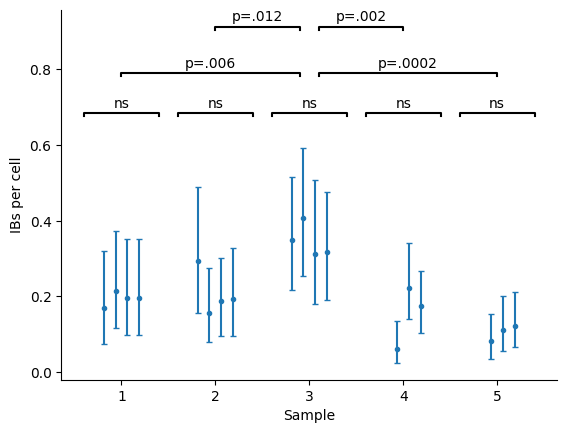

In [98]:
def plot_ib_number(ax=None):
    if ax is None: fig, ax = plt.subplots()
    
    split_plot(
        celltable, ax, 
        x_major='sample_id', x_minor='repeat', 
        y='cell_num_ibs',
        kind='error',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        hue='C0',
        minor_order=[1,2,3,4],
    )
    
    ax.set_xlabel('Sample')
    ax.set_ylabel('IBs per cell')
    sns.despine(ax=ax)
    # ax.set_xticks(range(1,6), ['MA', 'MB', 'MC', 'O', 'J'])
    # ax.set_yscale('symlog')
    # ax.set_yticks([0,1,2,3,4])
    # ax.set_yticklabels([0,1,2,3,4])

    annot(ax, [1,2,3,4,5], .4,'ns')
    # annot(ax, [1.95, 4.05], .95, ['p=0.006','p=0.002'])
    # annot(ax, [2.45, 3.55], .45, ['p=0.012','p=0.0002'])
    # annot(ax, [1.95, 3.55], [.95, .45], ['p=.006', 'p=.0002'])
    # annot(ax, [2.45, 4.05], [.45, .95], ['p=.012', 'p=.002'])

    annot(ax, [1.95, 4.05], .95, ['p=.006', 'p=.0002'])
    annot(ax, [2.45, 3.55], .45, ['p=.012', 'p=.002'])

plot_ib_number()

No technical variability

In [99]:
test_mean_differences(
    celltable, 
    outcome='cell_num_ibs', 
    groupby='sample_id', 
    subgroups='repeat'
)

reject_H0  using_anova    p_anova  p_kruskal  \
sample_id                                                      
wt_repeats_J10      False        False   0.528320   0.695510   
wt_repeats_M1A      False        False  26.989090  26.576057   
wt_repeats_M1B      False        False  11.937942  20.289778   
wt_repeats_M1C      False        False  23.081068  22.014184   
wt_repeats_O21      False        False  19.994571  22.428015   

                           p_shapiro    p_bartlett       n_per_group  \
sample_id                                                              
wt_repeats_J10       [0.0, 0.0, 0.0]  8.896568e-07      [82, 85, 86]   
wt_repeats_M1A  [0.0, 0.0, 0.0, 0.0]  2.682787e+01  [53, 51, 51, 51]   
wt_repeats_M1B  [0.0, 0.0, 0.0, 0.0]  9.671891e-02  [51, 51, 53, 52]   
wt_repeats_M1C  [0.0, 0.0, 0.0, 0.0]  1.256508e+01  [60, 59, 61, 63]   
wt_repeats_O21       [0.0, 0.0, 0.0]  8.676010e-01      [85, 89, 90]   

                bonferroni_multiplier  
sample_id                              
wt_repeats_J10                     28  
wt_repeats_M1A                     28  
wt_repeats_M1B                     28  
wt_repeats_M1C                     28  
wt_repeats_O21                     28

Some biological variability. MC: According to Tukey's HSD test, only MC is different from the rest.

In [100]:
test_mean_differences(
    celltable, 
    outcome='cell_num_ibs', 
    groupby='sample_id', 
    mean_over='repeat'
)

reject_H0                                               True
using_anova                                             True
p_anova                                             0.001931
p_kruskal                                           0.119459
p_shapiro                [3.997, 4.361, 1.498, 2.363, 3.205]
p_bartlett                                          1.390202
n_per_group                                  [3, 4, 4, 4, 3]
bonferroni_multiplier                                      7
dtype: object

In [101]:
import utils
utils.tukey_hsd(
    celltable,
    outcome='cell_num_ibs',
    groupby='sample_id',
    mean_over='repeat'
)

<class 'statsmodels.iolib.table.SimpleTable'>

## Size

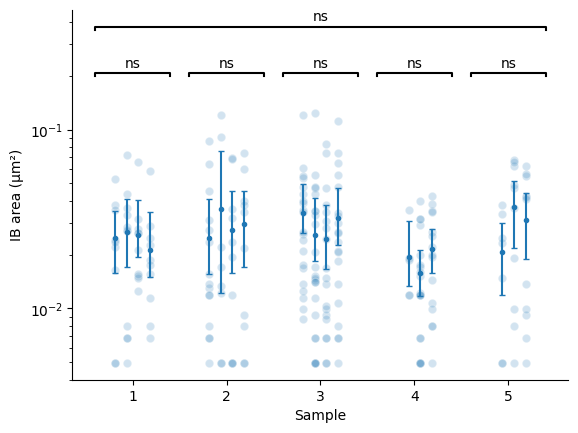

In [102]:
def plot_ib_size(ax=None):
    if ax is None: fig, ax = plt.subplots()
    split_plot(
        ibtable, ax, 
        x_major='sample_id', x_minor='repeat', 
        y='ib_area', 
        alpha=.2,
        kind='both',
        major_order=['wt_repeats_M1A', 'wt_repeats_M1B', 'wt_repeats_M1C', 'wt_repeats_J10', 'wt_repeats_O21'],
        minor_order=[1,2,3,4],
        hue='C0',
    )
    ax.set_yscale('log')
    ax.set_ylabel('IB area (µm²)')
    ax.set_xlabel('Sample')
    sns.despine(ax=ax)
    # ax.set_xticks(range(1,6), ['MA', 'MB', 'MC', 'O', 'J'])

    annot(ax, [1,2,3,4,5], .4, 'ns')
    annot(ax, 3, 2.4, 'ns')

plot_ib_size()

No technical variability

In [103]:
print(8.998/28)
test_mean_differences(
    ibtable, 
    outcome='ib_area', 
    groupby='sample_id', 
    subgroups='repeat'
)

0.32135714285714284


reject_H0  using_anova    p_anova  p_kruskal  \
sample_id                                                      
wt_repeats_J10      False         True   9.732589   8.948659   
wt_repeats_M1A      False         True  24.857151  24.316661   
wt_repeats_M1B      False         True  23.825418  27.666396   
wt_repeats_M1C      False        False  15.334642   6.069625   
wt_repeats_O21      False         True   8.998731   8.650031   

                                    p_shapiro  p_bartlett       n_per_group  \
sample_id                                                                     
wt_repeats_J10          [3.063, 0.498, 9.356]   21.931626       [5, 19, 15]   
wt_repeats_M1A  [18.177, 3.172, 0.096, 0.625]   20.841074   [9, 11, 10, 10]   
wt_repeats_M1B   [0.057, 0.096, 1.149, 5.417]    4.386049   [15, 8, 10, 10]   
wt_repeats_M1C   [0.031, 0.001, 0.034, 0.107]   25.012373  [21, 24, 19, 20]   
wt_repeats_O21          [13.66, 3.996, 1.307]    7.963746       [7, 10, 11]   

                bonferroni_multiplier  
sample_id                              
wt_repeats_J10                     28  
wt_repeats_M1A                     28  
wt_repeats_M1B                     28  
wt_repeats_M1C                     28  
wt_repeats_O21                     28

No biological variability

In [104]:
test_mean_differences(
    ibtable, 
    outcome='ib_area', 
    groupby='sample_id', 
    mean_over='repeat'
)

reject_H0                                              False
using_anova                                             True
p_anova                                             0.409783
p_kruskal                                           0.766761
p_shapiro                [4.832, 3.946, 4.945, 2.584, 4.729]
p_bartlett                                          2.963983
n_per_group                                  [3, 4, 4, 4, 3]
bonferroni_multiplier                                      7
dtype: object

## Location

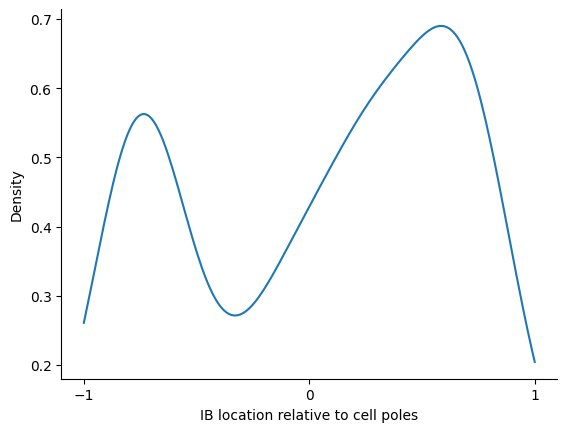

In [105]:
def plot_ib_location(ax=None):
    if ax is None: fig, ax = plt.subplots()
    sns.kdeplot(
        ibtable.query('cell_eccentricity>.9').ib_polar_projection, 
        ax=ax, clip=[-1,1], bw_adjust=.8,
        c='C0',
    )
    sns.despine(ax=ax)
    ax.set_xlabel('IB location relative to cell poles')
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))

plot_ib_location()

# Composite

(-18.737801467219054, 50.956882006011114)


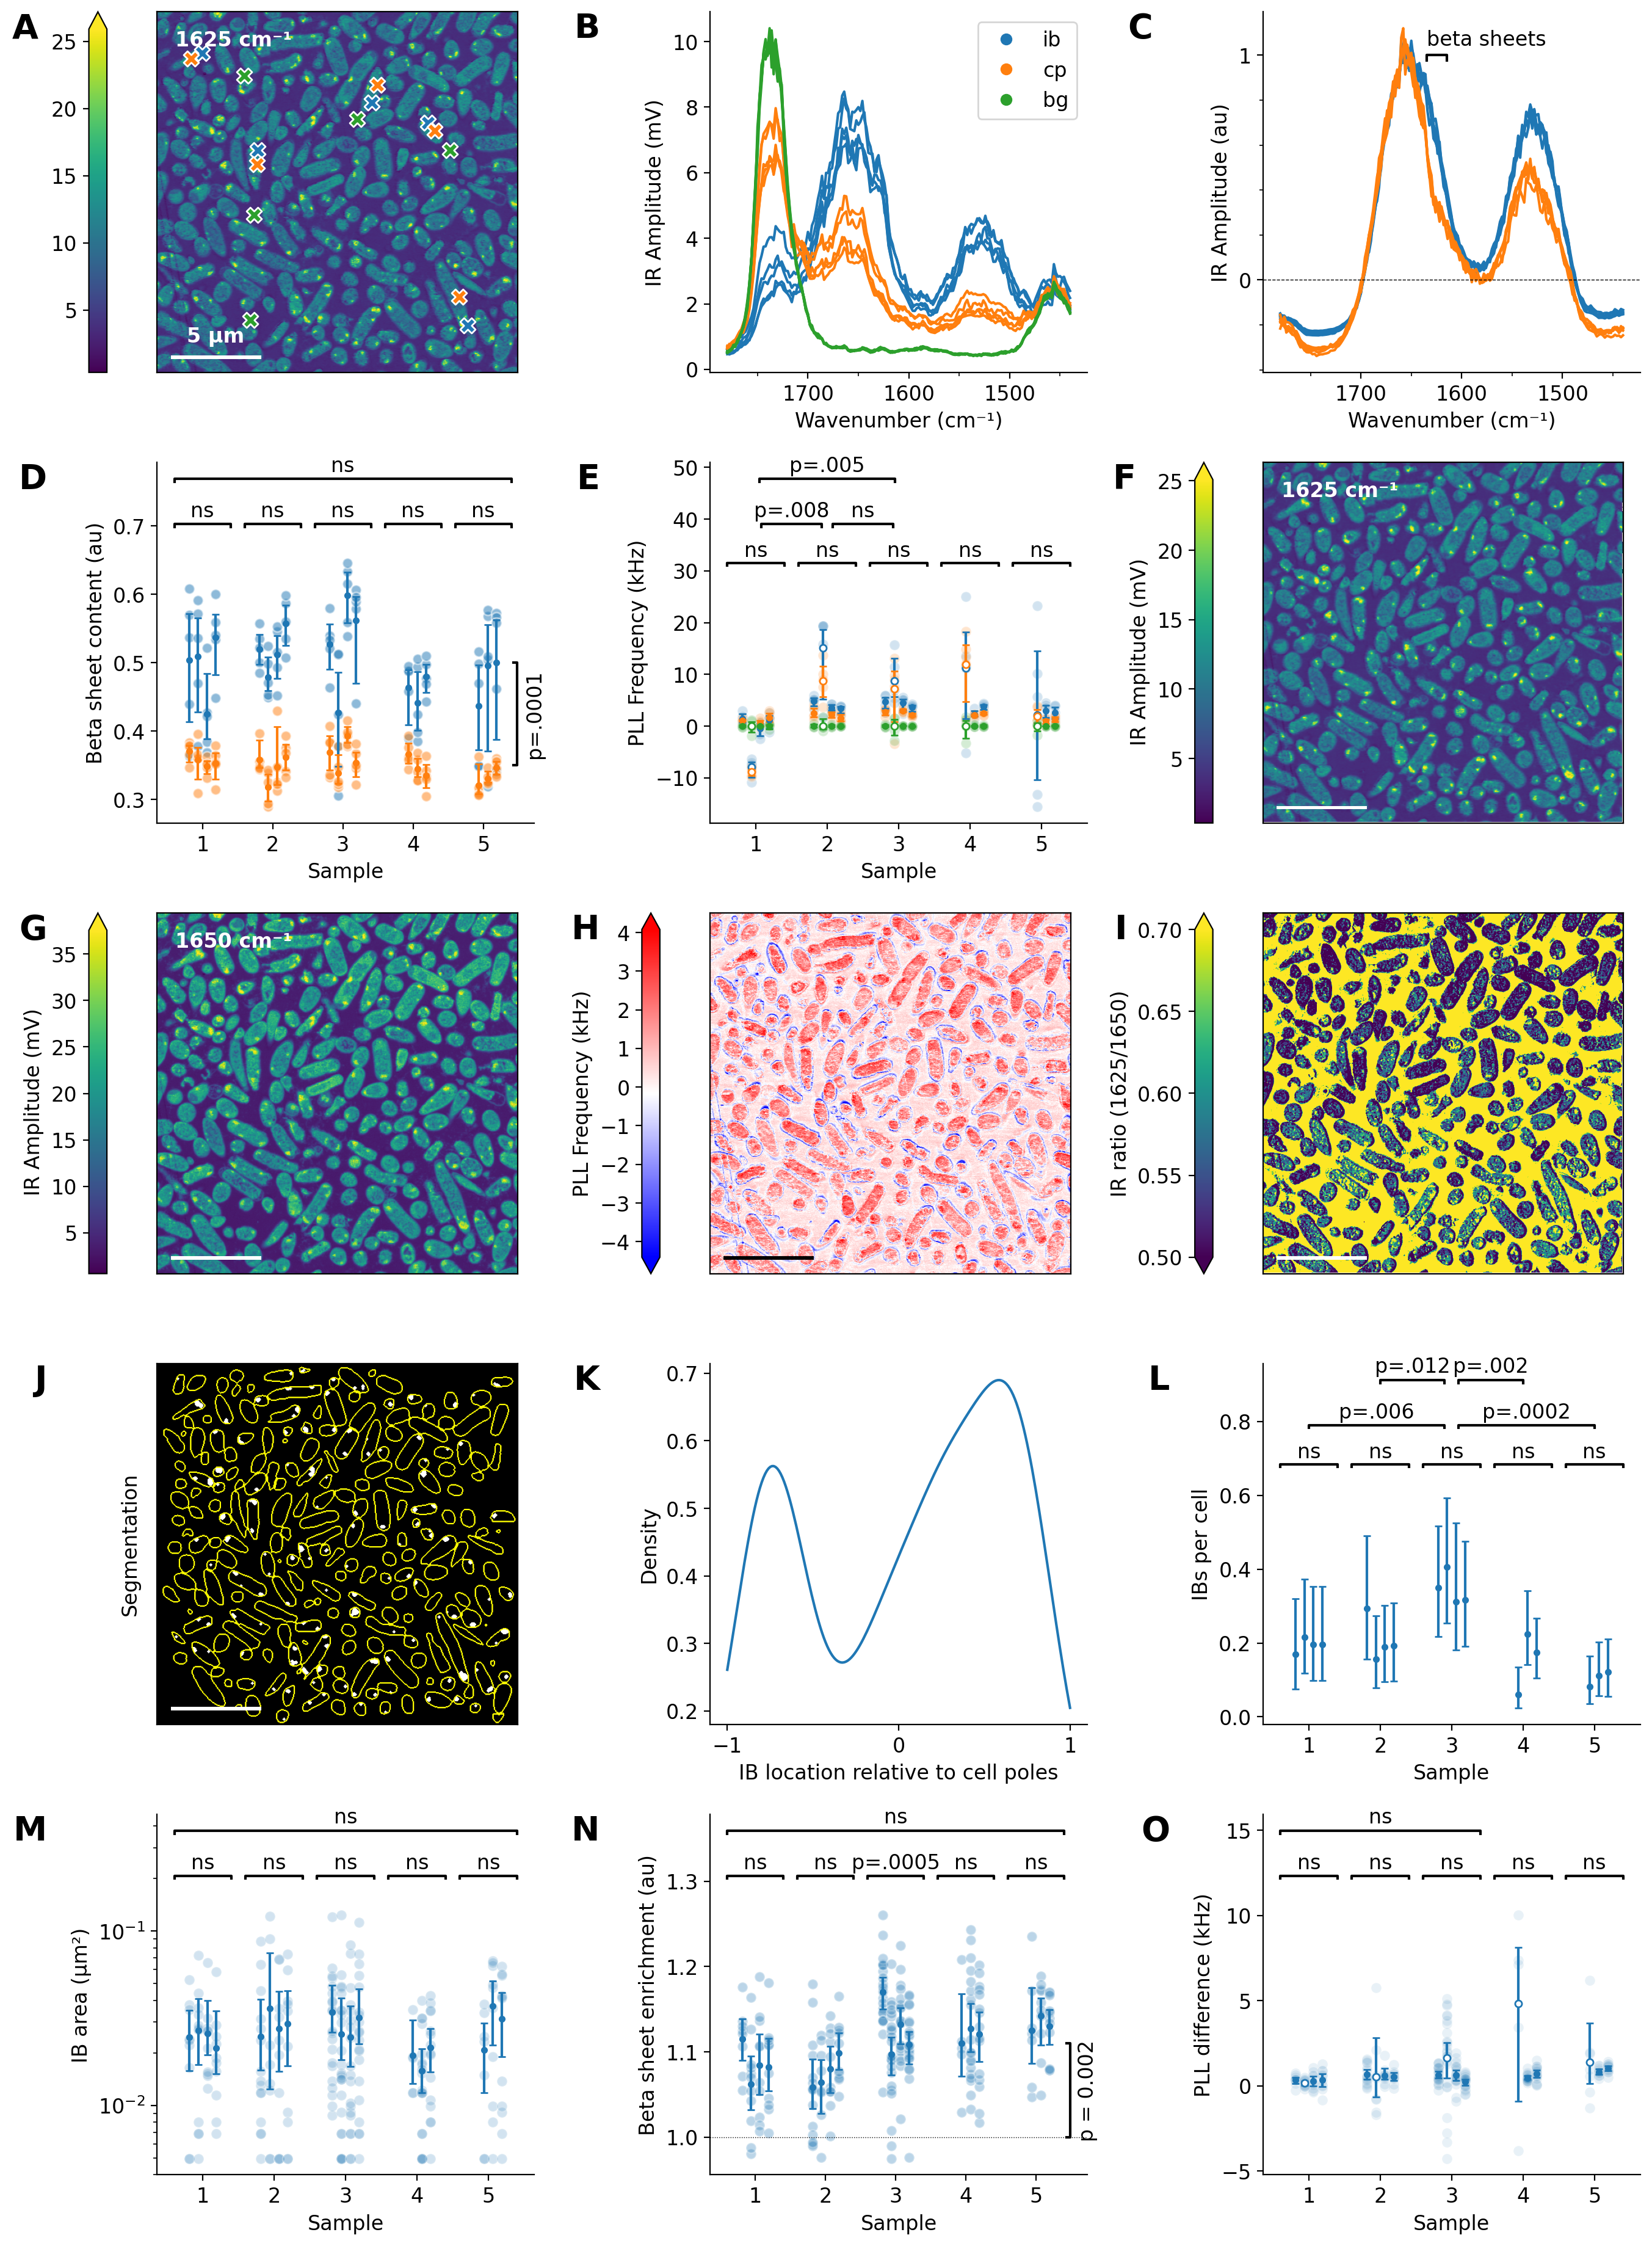

In [107]:
with plt.rc_context({
    'figure.figsize': (17,23),
    'figure.dpi': 200,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):

    fig, ax = plt.subplot_mosaic(
        gridspec_kw={'wspace': .1, 'hspace':.25},
        mosaic=[
            ['a', 'b', 'c'],
            ['d', 'e', 'f'],
            ['g', 'h', 'i'],
            ['j', 'k', 'l'],
            ['m', 'n', 'o'],
    ])

    plot_spectrum_example(ax=[ax['a'], ax['c'], ax['b']])
    plot_spectrum_stats([ax['d'], ax['e']])
    plot_maps_example(ax=[ax['f'], ax['g'], ax['h'], ax['i'], ax['j']])
    plot_ib_location(ax=ax['k'])
    plot_ib_number(ax=ax['l'])
    plot_ib_size(ax=ax['m'])
    plot_map_beta(ax=ax['n'])
    plot_map_pll_diff(ax=ax['o'])

    def pretend_colorbar(a, loc='right'):
        cb = plt.colorbar(ax['a'].images[0], ax=a, location=loc)
        cb.ax.set_visible(False)

    kwargs = dict(ha='right', va='top', xycoords=('axes points', 'axes fraction'), fontsize=20, fontweight='bold')
    # xy = (-55, 1)
    # for a in 'adgjm':
    #     ax[a].annotate(a.capitalize(), (-75, 1.04), **kwargs)
    # for a in 'bcefhiklno':
    #     ax[a].annotate(a.capitalize(), (-40,.99), **kwargs)

    ax['a'].annotate('A', (-70, 1), **kwargs)
    ax['b'].annotate('B', (-65, 1), **kwargs)
    ax['c'].annotate('C', (-65, 1), **kwargs)
    ax['d'].annotate('D', (-65, 1), **kwargs)
    ax['e'].annotate('E', (-65, 1), **kwargs)
    ax['f'].annotate('F', (-75, 1), **kwargs)
    ax['g'].annotate('G', (-65, 1), **kwargs)
    ax['h'].annotate('H', (-65, 1), **kwargs)
    ax['i'].annotate('I', (-80, 1), **kwargs)
    ax['j'].annotate('J', (-65, 1), **kwargs)
    ax['k'].annotate('K', (-65, 1), **kwargs)
    ax['l'].annotate('L', (-55, 1), **kwargs)
    ax['m'].annotate('M', (-65, 1), **kwargs)
    ax['n'].annotate('N', (-65, 1), **kwargs)
    ax['o'].annotate('O', (-55, 1), **kwargs)

    for a in 'bcdejklmno':
        pretend_colorbar(ax[a], loc='left')
    
    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    fig.savefig('../figures/figure_2.pdf', bbox_inches='tight')